# Notebook \#2 - Implementation of Fourier Neural Operator

In this beginning notebook, I am going to construct a framework for learning neural operators using the Fourier Neural Operator (FNO) architecture and solve a Diffusion Problem (to be explained later). The structure of this notebook goes as follows:
- Implement a class for the FNO architecture
- Implement a function for training the FNO with given differential equations and initial/boundary conditions
- Generate a training dataset for the input control functions and the corresponding analytical solutions of the differential equation
- Define loss functions associated with physics loss, initial, and boundary conditions
- Train the FNO
- Solve the Feldbaum Problem

Let's start by implementing the Fourier Neural Operator architecture.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.fft import fft, ifft
import numpy as np
from datetime import datetime
from data import MultiFunctionDatasetODE, custom_collate_ODE_fn 
import plotter  

## Key Components of the FNO Architecture

### 1. Input Lifting with an MLP

- **Purpose:**  
  The first step is to "lift" the input data—typically low-dimensional features (e.g., time `t` and a function `u`)—into a higher-dimensional feature space. This is done using a Multi-Layer Perceptron (MLP).

- **Implementation:**  
  An MLP is built using a list of layer sizes (e.g., `[2, n_hid, n_hid]`) and corresponding activation functions (e.g., `['tanh', 'tanh']`). This network transforms the concatenated input `(t, u)` into a lifted representation suitable for spectral processing.

---

### 2. Spectral Convolution with Fourier Layers

- **Fourier Transform:**  
  The FNO converts the lifted input into the frequency domain using the Fast Fourier Transform (FFT). For example, in the code:

```python
  x_ft = fft(x, dim=-1)
```
#### Learnable Spectral Filtering:
In the frequency domain, a subset of the Fourier modes (specifically the lower modes, which capture the most significant features) is filtered using learnable weights. This is achieved via an efficient tensor contraction with torch.einsum:
out_ft[:, :, :self.modes] = torch.einsum("bcm,cio->bio", x_ft[:, :, :self.modes], self.weights)
Here:
```python
x_ft[:, :, :self.modes] represents the selected Fourier modes.
```
`self.weights` are learnable parameters with shape `(in_channels, out_channels, modes)`.
#### Inverse Fourier Transform:
After applying the spectral filter, the data is transformed back to the spatial domain using the inverse FFT:
```python
x_out = ifft(out_ft, dim=-1)
return x_out.real
```
Only the real part of the inverse transform is used.
#### Stacking Layers:
Multiple Fourier layers can be stacked to enhance the model’s capacity. An optional nonlinearity (such as tanh) can be applied after each Fourier layer.

### 3. Output Projection with an MLP
***Purpose:***
After spectral convolution, the data is still in a high-dimensional space. An output MLP projects this representation back to the desired output dimension (typically a scalar per input point).
***Implementation:***
Similar to the input MLP, the output MLP is built using a list of layer sizes (e.g., `[n_hid, n_hid, 1]`) and corresponding activation functions (e.g., `['tanh', None]`).


In [ ]:
# ------------------------
# Fourier Layer Definition
# ------------------------
class FourierLayer(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        """
        Applies a Fourier transform to the input, uses a learnable spectral filter, and transforms back.
        Parameters:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            modes (int): Number of Fourier modes to keep.
        """
        super(FourierLayer, self).__init__()
        self.modes = modes
        self.scale = 1 / (in_channels * out_channels)
        # Weight shape: (in_channels, out_channels, modes)
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes, dtype=torch.cfloat))

    def forward(self, x):
        # x shape: (B, in_channels, N)
        x_ft = fft(x, dim=-1)  # Fourier transform: shape (B, in_channels, N)
        B, C, N = x_ft.shape
        # Initialize output tensor in Fourier space
        out_ft = torch.zeros(B, self.weights.shape[1], N, device=x.device, dtype=torch.cfloat)
        # Correct einsum: contract over the input channels while keeping the Fourier modes separate.
        out_ft[:, :, :self.modes] = torch.einsum("bcm,cim->bim", x_ft[:, :, :self.modes], self.weights)
        # Return to physical space via inverse FFT (real part only)
        x_out = ifft(out_ft, dim=-1)
        return x_out.real

# ------------------------
# Flexible FNO Model with Residual Connections
# ------------------------
class FNO(nn.Module):
    def __init__(self, input_net, fourier_layers_config, output_net,
                 input_activations, output_activations, fourier_activation=None):
        """
        Flexible Fourier Neural Operator.
        Parameters:
            input_net (list): List of integers for the input MLP architecture.
            fourier_layers_config (list): List of (modes, width) tuples for each Fourier layer.
            output_net (list): List of integers for the output MLP architecture.
            input_activations (list): List of activation names (or None) for the input MLP.
            output_activations (list): List of activation names (or None) for the output MLP.
            fourier_activation (str or None): Optional activation (e.g. 'tanh') applied after each Fourier layer.
        """
        super(FNO, self).__init__()
        self.input_mlp = self.build_mlp(input_net, input_activations)
        
        # Create Fourier layers
        self.fourier_layers = nn.ModuleList([
            FourierLayer(width, width, modes) for (modes, width) in fourier_layers_config
        ])
        self.fourier_activation = self.get_activation(fourier_activation) if fourier_activation is not None else None

        self.output_mlp = self.build_mlp(output_net, output_activations)

    def build_mlp(self, layers, activations):
        """Builds an MLP from a list of layer sizes and corresponding activation names."""
        modules = []
        for i in range(len(layers) - 1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            if activations[i] is not None:
                modules.append(self.get_activation(activations[i]))
        return nn.Sequential(*modules)

    def get_activation(self, act_name):
        act_name = act_name.lower()
        if act_name == 'tanh':
            return nn.Tanh()
        elif act_name == 'relu':
            return nn.ReLU()
        elif act_name == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation: {act_name}")

    def forward(self, t, u):
        
        # t and u are now both [batch, seq_len]. Unsqueeze to add a feature dimension before concatenating.
        x = torch.cat((t.unsqueeze(-1), u.unsqueeze(-1)), dim=-1)
        x = self.input_mlp(x)  # Lifting via input MLP -> (B, seq_len, width)
        x = x.permute(0, 2, 1)  # Rearranging for Fourier layers: (B, width, seq_len)
        
        # Fourier layers with residual connections
        for layer in self.fourier_layers:
            residual = x
            x = layer(x)
            if self.fourier_activation is not None:
                x = self.fourier_activation(x)
            x = x + residual  # Residual connection

        x = x.permute(0, 2, 1)  # Back to (B, seq_len, width)
        x = self.output_mlp(x)  # Project to output -> (B, seq_len, 1)
        return x.squeeze(-1)

# ------------------------
# Loss and Training Functions
# ------------------------
def compute_loss(model, u, t, t0, ut, dim_x=1):
    x = model(t, u)
    batch_size = u.shape[0]
    n_points = t.shape[1]  # Correct: using seq_len (t is [B, seq_len])

    # Physics loss
    dx = torch.zeros(batch_size, n_points, dim_x, device=t.device)
    
    # Compute gradients for each sample independently
    for b in range(batch_size):
        dx[b] = torch.autograd.grad(x[b], t[b], torch.ones_like(x[b]), create_graph=True
        )[0]

    dx_dt = dx[:, :, 0]
    physics = dx_dt + x - u
    physics_loss = torch.mean(physics ** 2)

    initial_loss = torch.mean((torch.ones_like(x[:, 0]) - x[:, 0]) ** 2)

    return physics_loss + initial_loss


def train(model, dataloader, optimizer, num_epochs=1000, lr=0.001, batch_size=64, plot=False, m=None, grf_lb=None, grf_ub=None):
    """
    Trains the model on the given dataset.
    Additional logging and model saving is done every few epochs.
    """
    
    for epoch in range(num_epochs):
        model.train()
        # Iterate over batches
        for u, t, t0, ut in dataloader:

            t.requires_grad_(True)
           
            loss = compute_loss(model, u, t, t0, ut)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
              f'physics_loss: {loss.item():.6f}, '
              f'time: {datetime.now().time()}')
        
        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
            model_filename = f'epochs_[{epoch}]_model_time_[{timestamp}]_loss_[{loss.item():.4f}].pth'
            torch.save(model.state_dict(), f"trained_models/fno/{model_filename}") 

# ------------------------
# Architecture hyperparameters for the flexible FNO
# ------------------------
n_hid = 250
modes = 16         # Increased Fourier modes as recommended
num_fourier_layers = 3  # Using 3 Fourier layers with residual connections

# Define the input MLP architecture: 2 input features -> n_hid -> n_hid
input_net = [2, n_hid, n_hid]
input_activations = ['tanh', 'tanh']

# Fourier layers configuration: list of (modes, width) tuples.
fourier_layers_config = [(modes, n_hid) for _ in range(num_fourier_layers)]
fourier_activation = 'tanh'

# Define the output MLP architecture: n_hid -> n_hid -> 1
output_net = [n_hid, n_hid, 1]
output_activations = ['tanh', None]

# Dataset parameters (adjust as needed)
m = 200   
n_functions = 10000
grf_lb = 0.02
grf_ub = 0.5
end_time = 1.0
num_domain = 200
num_initial = 20
batch_size = 128

# Assuming MultiFunctionDatasetODE is defined elsewhere
dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial', 'constant'],
    end_time=end_time,
    num_domain=num_domain,
    num_initial=num_initial,
    grf_lb=grf_lb,
    grf_ub=grf_ub
)

dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=custom_collate_ODE_fn, shuffle=True)

# Initialize the model and move it to GPU.
model = FNO(input_net, fourier_layers_config, output_net,
            input_activations, output_activations, fourier_activation).cuda()

# Training hyperparameters
epochs = 2000
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Start training with optional plotting enabled.
train(model, dataloader, optimizer, epochs=epochs, lr=lr, batch_size=batch_size,
      plot=True, m=m, grf_lb=grf_lb, grf_ub=grf_ub)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
def objective_function(n, args):
    """
    Compute the objective:
      J(u) = 0.5 * ∫₀¹ (x² + u²) dt + penalty terms,
    enforcing:
      dx/dt - (x - u) = 0  and  x(0) = 1.
    
    Args:
        n (int): Batch size.
        args (dict): Contains:
            'x': Predicted state tensor of shape (n, m),
            'u': Control tensor of shape (n, m),
            't': Time tensor of shape (n, m).
    
    Returns:
        J (Tensor): The total objective (scalar).
    """
    # Assuming the state x is scalar so dim_x = 1.
    dim_x = 1
    m = args['t'].shape[1]
    dx = torch.zeros(n, m, dim_x, device=args['t'].device)
    
    # Compute time derivative for each batch element.
    for b in range(n):
        grad_val = torch.autograd.grad(
            args['x'][b],
            args['t'][b],
            torch.ones_like(args['x'][b]),
            create_graph=True,
            allow_unused=True  # allow unused gradients
        )[0]
        # Substitute with zeros if grad_val is None.
        if grad_val is None:
            grad_val = torch.zeros_like(args['t'][b])
        # Unsqueeze to make shape (m, 1) so it can be assigned to dx[b] which is (m, 1)
        dx[b] = grad_val.unsqueeze(-1)
    
    # Squeeze to shape (n, m)
    dx_dt = dx[:, :, 0]

    # Physics residual: dx/dt - (x - u) should be 0.
    physics = dx_dt - args['x'] + args['u']
    physics_loss = torch.mean(physics**2)
    
    # Initial condition penalty: x(0) should equal 1.
    initial_loss = torch.mean((args['x'][:, 0] - torch.ones(n, device=args['t'].device))**2)

    # Cost functional: 0.5 * ∫₀¹ (x² + u²) dt computed via the trapezoidal rule.
    cost_integral = torch.trapz((args['x']**2 + args['u']**2).squeeze(), args['t'].squeeze(), dim=-1)
    cost = 0.5 * torch.mean(cost_integral)

    # Total objective: cost + weighted penalty terms.
    J = cost + 100 * physics_loss + 10 * initial_loss
    return J

# ------------------------
# Gradient Descent Routine (Batched Version)
# ------------------------
def gradient_descent(n, alpha, m, num_epochs, model, objective_function):
    """
    Minimizes the objective with respect to the control u.
    
    Args:
        n (int): Batch size.
        alpha (float): Learning rate.
        m (int): Number of time points (sensors).
        num_epochs (int): Number of training epochs.
        model (nn.Module): Your trained FNO model that computes x = model(t, u).
        objective_function (function): Computes the cost given u, t, and model output.
        
    Returns:
        u_opt (Tensor): Optimized control averaged over the batch (shape: [m]).
    """
    # Initialize control u with shape (n, m)
    u = torch.zeros(n, m, device=device)
    
    # Create time grid of shape (n, m) by repeating the same 1D time vector
    t = torch.linspace(0, end_time, m, device=device).unsqueeze(0).repeat(n, 1)
    
    u.requires_grad_(True)
    t.requires_grad_(True)  # if you need gradients for t
    
    optimizer = torch.optim.Adam([u], lr=alpha)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        x = model(t, u)  # FNO model returns x with shape (n, m)
        args = {'x': x, 'u': u, 't': t}
        loss = objective_function(n, args)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 ==0:
        
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, time: {datetime.now().time()}')

    # Return the optimized control averaged over the batch (shape: (m,))
    return torch.mean(u, axis=0)

# ------------------------
# Hyperparameters and Model Loading
# ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = 1      # Batch size (number of random functions)
m = 200       # Number of time points (sensors)
num_epochs = 10000
alpha = 0.001

# (Assume your FNO model class definition is available)
# Instantiate and load your trained FNO model.
trained_model = FNO(input_net, fourier_layers_config, output_net,
                    input_activations, output_activations, fourier_activation)
trained_model.to(device)
trained_model.load_state_dict(torch.load('trained_models/fno/epochs_[29]_model_time_[20250317-233106]_loss_[0.0022].pth', map_location=device))
trained_model.eval()

# ------------------------
# Run Gradient Descent to Optimize u
# ------------------------
u_opt = gradient_descent(n, alpha, m, num_epochs, trained_model, objective_function)
print("Optimized control u(t):", u_opt)


Epoch [100/10000], Loss: 80.9266, time: 23:49:29.549457
Epoch [200/10000], Loss: 65.2099, time: 23:49:31.365285
Epoch [300/10000], Loss: 51.9507, time: 23:49:33.178772
Epoch [400/10000], Loss: 40.8849, time: 23:49:35.048521
Epoch [500/10000], Loss: 31.7614, time: 23:49:36.892618
Epoch [600/10000], Loss: 24.3421, time: 23:49:38.707690
Epoch [700/10000], Loss: 18.4008, time: 23:49:40.521186
Epoch [800/10000], Loss: 13.7241, time: 23:49:42.337332
Epoch [900/10000], Loss: 10.1120, time: 23:49:44.149442
Epoch [1000/10000], Loss: 7.3797, time: 23:49:45.965797
Epoch [1100/10000], Loss: 5.3596, time: 23:49:47.784414
Epoch [1200/10000], Loss: 3.9026, time: 23:49:49.602192
Epoch [1300/10000], Loss: 2.8793, time: 23:49:51.417265
Epoch [1400/10000], Loss: 2.1808, time: 23:49:53.231967
Epoch [1500/10000], Loss: 1.7184, time: 23:49:55.049967
Epoch [1600/10000], Loss: 1.4220, time: 23:49:56.898932
Epoch [1700/10000], Loss: 1.2383, time: 23:49:58.719864
Epoch [1800/10000], Loss: 1.1284, time: 23:50:00

KeyboardInterrupt: 

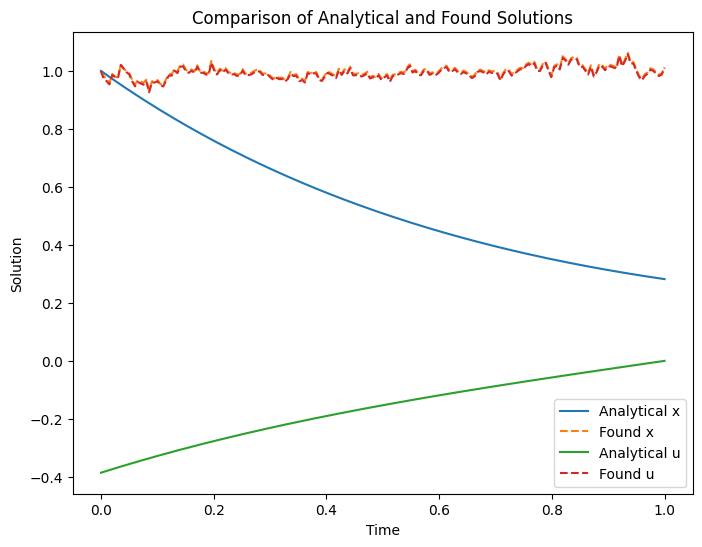

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Define analytical solutions using NumPy (if not defined yet)
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

# Create a time grid for plotting. Here t_plot is a NumPy array of shape (m,)
t_plot = np.linspace(0, end_time, m)

# Compute analytical solutions.
analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)

# Prepare inputs for the FNO model.
# u_opt is assumed to be the optimized control (1D tensor of shape (m,))
# We create a time tensor of shape (1, m) and a control tensor of shape (1, m)
t_tensor = torch.linspace(0, end_time, m, device=device).unsqueeze(0)
u_tensor = u_opt.unsqueeze(0)

# Get the FNO model output.
x_found = trained_model(t_tensor, u_tensor)  # Expected shape: (1, m)
x_found = x_found.cpu().detach().numpy().flatten()  # Flatten to shape (m,)
u_found = u_opt.cpu().detach().numpy()  # Already shape (m,)

# Plot the results.
plt.figure(figsize=(8, 6))
plt.plot(t_plot, analytical_x_vals, label="Analytical x")
plt.plot(t_plot, x_found, label="Found x", linestyle='--')
plt.plot(t_plot, analytical_u_vals, label="Analytical u")
plt.plot(t_plot, u_found, label="Found u", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Solution")
plt.legend()
plt.title("Comparison of Analytical and Found Solutions")
plt.show()
